In [63]:
suppressPackageStartupMessages({
  library(tidyverse)
  library(reticulate)
  library(GenomicRanges)
  library(tmpRpkg)
  library(ComplexHeatmap)
  #library(magick)
})
# change the size of figures shown in jupyter
options(repr.plot.width=15, repr.plot.height=8)
Sys.setenv("_R_USE_PIPEBIND_" = TRUE)

In [14]:
# meta
projd <- here::here()
hmd <- file.path(projd, "10.superEnhancer", "out", "heatmap")
supenhd <- file.path(projd, "10.superEnhancer", "out", "ROSE")
scs <- list.files(supenhd, full.names = FALSE, no.. = TRUE, all.files = FALSE)

In [ ]:
# functions

In [15]:
loadSuperEnhancer <- function(sc) {
    data.table::fread(
        file = file.path(supenhd, sc, str_glue("{sc}_AllStitched.table.txt")),
        head = TRUE, sep = "\t", skip = "#", data.table = FALSE
    )
}

In [ ]:
# load superEnhancers

In [16]:
supenhl <- lapply(scs, loadSuperEnhancer) |>
  setNames(object = _, nm = scs)

In [17]:
flatEnhs <- do.call(rbind, supenhl)
flatEnhs$sc <- do.call("c", lapply(scs, \(sc) {
  rep(sc, nrow(supenhl[[sc]]))
}))
flatSuperEnhs <- flatEnhs[flatEnhs$isSuper > 0, ]
rownames(flatSuperEnhs) <- with(
  flatSuperEnhs,
  paste(sc,
    paste(CHROM, paste(START, STOP, sep = "-"), sep = ":"),
    sep = "@")
)

In [21]:
str(flatEnhs)
message("Only Super Enhancers identified by ROSE:")
str(flatSuperEnhs)

'data.frame':	2975958 obs. of  10 variables:
 $ REGION_ID       : chr  "7_CRE_lociStitched" "7_CRE_lociStitched" "6_CRE_lociStitched" "5_CRE_lociStitched" ...
 $ CHROM           : chr  "chr2" "chr9" "chr2" "chr1" ...
 $ START           : int  45098951 56650894 57094359 86434377 78201374 25553645 84073561 172308162 108120015 152567878 ...
 $ STOP            : int  45115291 56694584 57113540 86442461 78211334 25565622 84088668 172325347 108138075 152593027 ...
 $ NUM_LOCI        : int  7 7 6 5 5 5 5 5 5 5 ...
 $ CONSTITUENT_SIZE: int  5231 3557 2844 2243 2416 1564 1281 2066 2041 1108 ...
 $ H3K27ac.srt.bam : num  67047 67047 38554 26539 26539 ...
 $ stitchedPeakRank: int  1 2 3 4 5 6 7 8 9 10 ...
 $ isSuper         : int  1 1 1 1 1 1 1 1 1 1 ...
 $ sc              : chr  "001_CLA_EPd_CTX_Car3_Glut" "001_CLA_EPd_CTX_Car3_Glut" "001_CLA_EPd_CTX_Car3_Glut" "001_CLA_EPd_CTX_Car3_Glut" ...


Only Super Enhancers identified by ROSE:



'data.frame':	147933 obs. of  10 variables:
 $ REGION_ID       : chr  "7_CRE_lociStitched" "7_CRE_lociStitched" "6_CRE_lociStitched" "5_CRE_lociStitched" ...
 $ CHROM           : chr  "chr2" "chr9" "chr2" "chr1" ...
 $ START           : int  45098951 56650894 57094359 86434377 78201374 25553645 84073561 172308162 108120015 152567878 ...
 $ STOP            : int  45115291 56694584 57113540 86442461 78211334 25565622 84088668 172325347 108138075 152593027 ...
 $ NUM_LOCI        : int  7 7 6 5 5 5 5 5 5 5 ...
 $ CONSTITUENT_SIZE: int  5231 3557 2844 2243 2416 1564 1281 2066 2041 1108 ...
 $ H3K27ac.srt.bam : num  67047 67047 38554 26539 26539 ...
 $ stitchedPeakRank: int  1 2 3 4 5 6 7 8 9 10 ...
 $ isSuper         : int  1 1 1 1 1 1 1 1 1 1 ...
 $ sc              : chr  "001_CLA_EPd_CTX_Car3_Glut" "001_CLA_EPd_CTX_Car3_Glut" "001_CLA_EPd_CTX_Car3_Glut" "001_CLA_EPd_CTX_Car3_Glut" ...


In [22]:
length(unique(with(flatSuperEnhs, paste(CHROM, 
                                        paste(START, STOP, sep = "-"),
                                       sep = ":"))))

[1] 135365

In [7]:
# load H3K27ac signals on superenh

In [10]:
K27acAllSE <- readRDS(
    file.path(hmd, "signalH3K27ac.allsuperEnhancer.scList.rds"))

In [23]:
allSEmat <- do.call(rbind, K27acAllSE)
colnames(allSEmat) <- rownames(flatSuperEnhs)

In [26]:
str(allSEmat)

 num [1:187, 1:147933] 27.2 13.3 12.8 15 14.2 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:187] "001_CLA_EPd_CTX_Car3_Glut" "002_IT_EP_CLA_Glut" "003_L5_6_IT_TPE_ENT_Glut" "004_L6_IT_CTX_Glut" ...
  ..$ : chr [1:147933] "001_CLA_EPd_CTX_Car3_Glut@chr2:45098951-45115291" "001_CLA_EPd_CTX_Car3_Glut@chr9:56650894-56694584" "001_CLA_EPd_CTX_Car3_Glut@chr2:57094359-57113540" "001_CLA_EPd_CTX_Car3_Glut@chr1:86434377-86442461" ...


In [27]:
quantile(rowSums(allSEmat))

0%      25%      50%      75%     100% 
375869.0 445835.0 475111.1 498877.3 609684.8

In [28]:
# divided by row
rowNormAllSEmat <- (allSEmat * 10^5) / rowSums(allSEmat)

In [29]:
str(rowNormAllSEmat)

 num [1:187, 1:147933] 5.7 2.79 2.71 3.08 2.96 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:187] "001_CLA_EPd_CTX_Car3_Glut" "002_IT_EP_CLA_Glut" "003_L5_6_IT_TPE_ENT_Glut" "004_L6_IT_CTX_Glut" ...
  ..$ : chr [1:147933] "001_CLA_EPd_CTX_Car3_Glut@chr2:45098951-45115291" "001_CLA_EPd_CTX_Car3_Glut@chr9:56650894-56694584" "001_CLA_EPd_CTX_Car3_Glut@chr2:57094359-57113540" "001_CLA_EPd_CTX_Car3_Glut@chr1:86434377-86442461" ...


In [30]:
scaleAllSEmat <- scale(rowNormAllSEmat, center = TRUE, scale = TRUE)

In [31]:
str(scaleAllSEmat)

 num [1:187, 1:147933] 2.665 0.631 0.573 0.831 0.751 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:187] "001_CLA_EPd_CTX_Car3_Glut" "002_IT_EP_CLA_Glut" "003_L5_6_IT_TPE_ENT_Glut" "004_L6_IT_CTX_Glut" ...
  ..$ : chr [1:147933] "001_CLA_EPd_CTX_Car3_Glut@chr2:45098951-45115291" "001_CLA_EPd_CTX_Car3_Glut@chr9:56650894-56694584" "001_CLA_EPd_CTX_Car3_Glut@chr2:57094359-57113540" "001_CLA_EPd_CTX_Car3_Glut@chr1:86434377-86442461" ...
 - attr(*, "scaled:center")= Named num [1:147933] 1.888 0.659 0.404 3.279 2.447 ...
  ..- attr(*, "names")= chr [1:147933] "001_CLA_EPd_CTX_Car3_Glut@chr2:45098951-45115291" "001_CLA_EPd_CTX_Car3_Glut@chr9:56650894-56694584" "001_CLA_EPd_CTX_Car3_Glut@chr2:57094359-57113540" "001_CLA_EPd_CTX_Car3_Glut@chr1:86434377-86442461" ...
 - attr(*, "scaled:scale")= Named num [1:147933] 1.43 0.423 0.467 1.451 1.551 ...
  ..- attr(*, "names")= chr [1:147933] "001_CLA_EPd_CTX_Car3_Glut@chr2:45098951-45115291" "001_CLA_EPd_CTX_Car3_Glut@chr9:56650894-56694584" "001

In [68]:
# remove supertype from subclass
sel_scs <- scs[vapply(scs, \(sc) {
    strsplit(sc, "_", fixed = TRUE) |> 
    unlist() |>
    x => as.integer(x[1])
}, 1L) < 500]
str(sel_scs)

 chr [1:164] "001_CLA_EPd_CTX_Car3_Glut" "002_IT_EP_CLA_Glut" ...


In [70]:
# downsample superEnhancers per sc to reduce the size of heatmap
nds <- 200
selSupEnhs <- lapply(sel_scs,
    \(sc) {
        e <- colnames(scaleAllSEmat)
        ind <- grepl(sc, e, fixed = TRUE)
        if (sum(ind) < 1) {
            message("No super enhancers found for ", sc)
            return(NULL)
        }
        e <- e[ind]
        a <- scaleAllSEmat[sc, e]
        r <- e[order(a, decreasing = TRUE)][1:min(nds, length(e))]
        return(r)
    }
) |> 
x => Filter(\(l) {!is.null(l)}, x) |>
x => do.call("c", x)

No super enhancers found for 070_LSX_Prdm12_Slit2_Gaba



In [72]:
p_ds <- Heatmap(scaleAllSEmat[sel_scs[!grepl("070_LSX_Prdm12_Slit2_Gaba", sel_scs)], selSupEnhs], 
                name = "H3K27ac signals on super enhancers identified by ROSE",
                cluster_rows = FALSE, show_row_dend = FALSE, show_row_names = FALSE,
                cluster_columns = FALSE, show_column_dend = FALSE, show_column_names = FALSE,
                show_heatmap_legend = TRUE,
                heatmap_legend_param = list(title = "Scaled Signals Per 10K"),
                use_raster = TRUE)

The automatically generated colors map from the minus and plus 99^th of
the absolute values in the matrix. There are outliers in the matrix
whose patterns might be hidden by this color mapping. You can manually
set the color to `col` argument.

Use `suppressMessages()` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



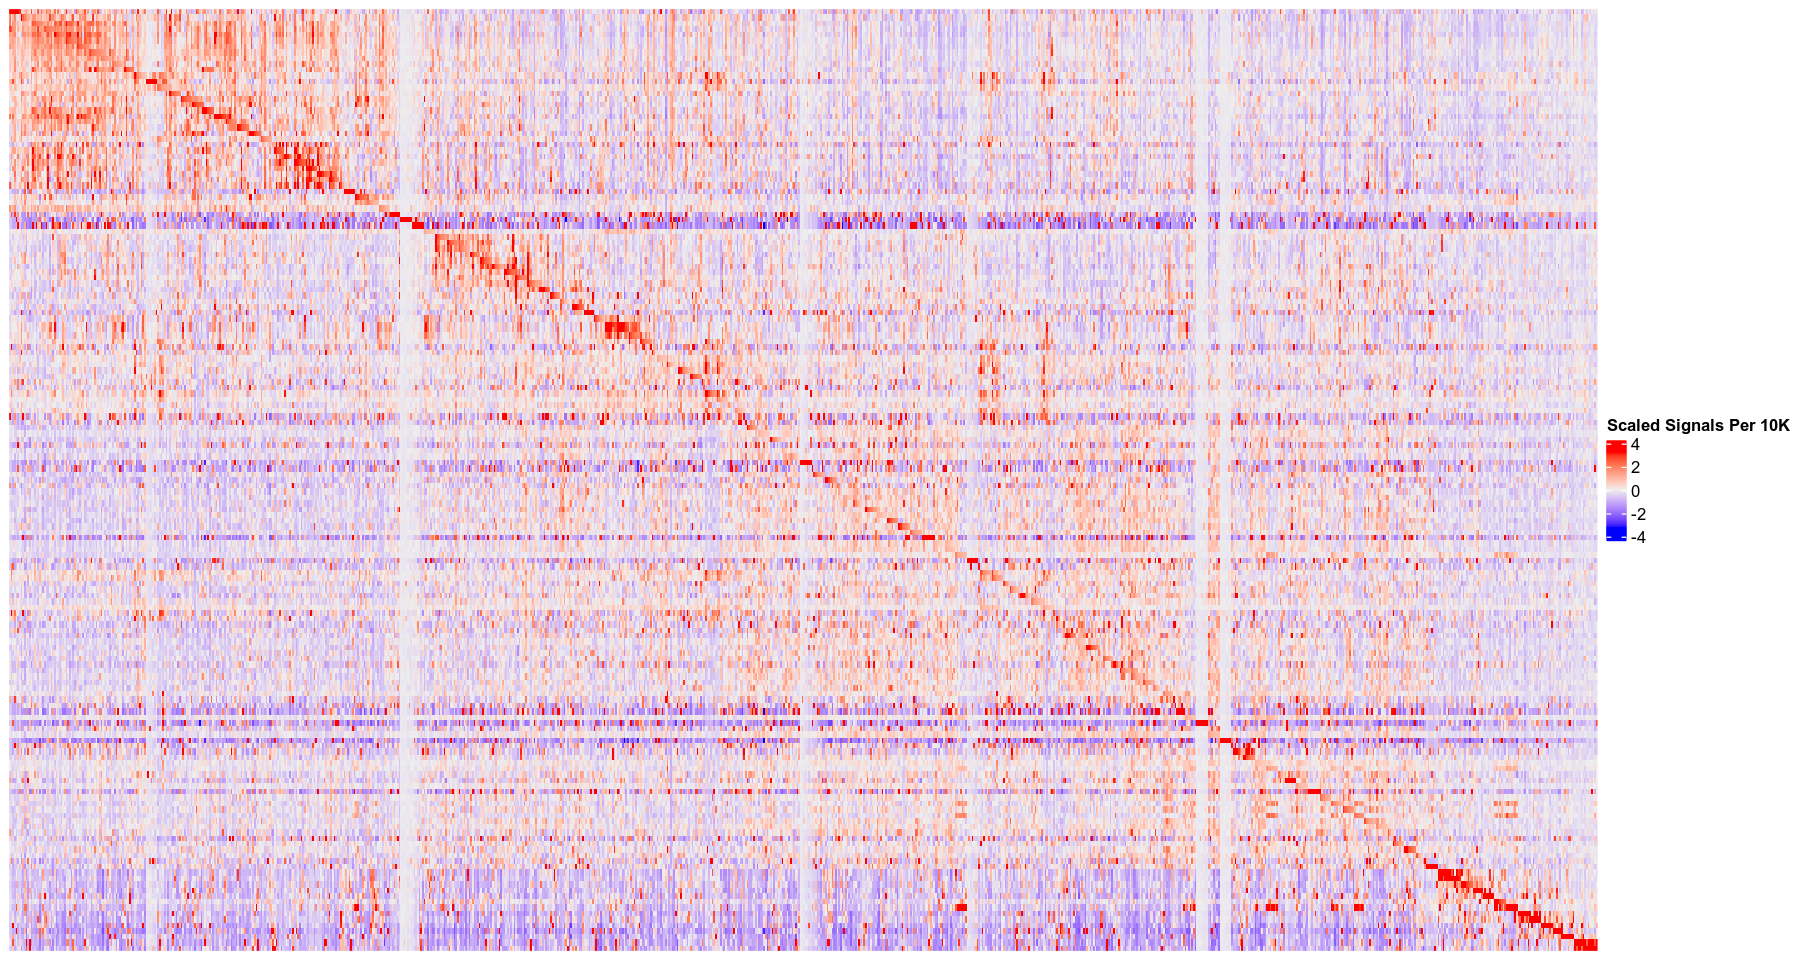

In [73]:
draw(p_ds)

In [ ]:
# save heatmap
